## Rationale for the visualisation

* generate bins of size 50 from 1 to 1,000
* the *Aeneid* contains 12 books (see dictionary below for consistency)
* create a matrix of 12 rows x 20 columns (dict of dicts)
    * initialise the value of each bin to 0 or None (if the bin scope falls outside the number of lines in the book)
* iterate through the results of the API and increment the count

1. generate empty matrix
2. get and store JSTOR MatchMaker data (quotations)
3. get and store CREX data (references)
4. iterate through quotations and update matrix
5. iterate through references and update matrix
6. output data in a d3.js-friendly JSON format

In [3]:
import matplotlib; matplotlib.use('Agg')
%matplotlib inline
import ConfigParser
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import json
import requests
import seaborn as sns;sns.set()
#from MyCapytain.common.reference import URN

/Users/rromanello/.pyenv/versions/phd-py2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
books = {
	1:756
	,2:804
	,3:719
	,4:705
	,5:871
	,6:901
	,7:817
	,8:731
	,9:818
	,10:908
	,11:915
	,12:952
}

In [5]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in xrange(0, len(l), n):
        yield l[i:i+n]

In [6]:
quotation_freq_matrix = {}
bins = {(bin[0],bin[-1]):bin for bin in list(chunks(range(1,1001),50))}
for urn in sorted(books.keys()):
    max_line_number = books[urn]
    temp = {}
    for range_start,range_end in bins.keys():
        if (range_start < max_line_number and range_end <= max_line_number):
            temp["%i-%i"%(range_start,range_end)] = 0
        elif(range_start < max_line_number and range_end > max_line_number):
            temp["%i-%i"%(range_start,range_end)] = 0
        else:
            temp["%i-%i"%(range_start,range_end)] = np.nan
    quotation_freq_matrix[urn] = temp

In [91]:
quotation_freq_df = pd.DataFrame.from_dict(quotation_freq_matrix)

In [93]:
quotation_freq_df

,1,2,3,4,5,6,7,8,9,10,11,12
1-50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
101-150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
151-200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
201-250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
251-300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
301-350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
351-400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
401-450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
451-500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
501-550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [96]:
data = json.loads(quotation_freq_df.to_json(orient="split"))

In [98]:
#data

In [99]:
temp = [{"chunk":data["index"][i]
  ,"book":data["columns"][j]
  ,"count":book} for i,chunk in enumerate(data["data"]) 
                                                         for j,book in enumerate(chunk)]

In [100]:
import codecs

In [101]:
outf = codecs.open("../data/quot_freq_empty2.json","w","utf-8")

In [102]:
json.dump(temp, outf)

## Query the MatchMaker API

### Add to the API's response the CTS URNs

In [2]:
parameters = {'work':'virgil_aeneid','limit':50000}

In [3]:
config = ConfigParser.ConfigParser(allow_no_value=True)
config.read("authentication.conf")

['authentication.conf']

In [4]:
response = requests.get('http://labs.jstor.org/apis/matchmaker/',params=parameters, auth=('mromanello','chohuka5'))

In [5]:
data = response.json()
print data.keys()
print data["count"]

[u'count', u'docs', u'previous', u'qtime', u'next']
11228


In [9]:
print data['count']

11228


In [6]:
for doc in data["docs"]:
    doc["chunk_urns"]  = [chunk_id.replace('<verg. aen. ','urn:cts:latinLit:phi0690.phi003:') .replace('>','')
                               for chunk_id in doc["chunk_ids"]]

### Iterate over the data and update the quotation frequency count

In [7]:
quoted_urns = [urn for doc in data["docs"] for urn in doc["chunk_urns"]]

In [8]:
len(quoted_urns)

29941

**Note**: 
- this way of counting the frequency has the problem of giving more importance to longer quotations
- to fix this, "compress" quotations before updating the count

In [14]:
for urn in quoted_urns:
    quoted_urn = URN(urn)
    book_n, line_n = quoted_urn.reference.list
    book_n = int(book_n)
    line_n = int(line_n)
    for start_range,end_range in bins:
        if (line_n >= start_range and line_n <= end_range):
            quotation_freq_df.loc[book_n]["%i-%i"%(start_range,end_range)]+=1

In [15]:
quotation_freq_df

,1-50,51-100,101-150,151-200,201-250,251-300,301-350,351-400,401-450,451-500,501-550,551-600,601-650,651-700,701-750,751-800,801-850,851-900,901-950,951-1000
1,592,326,219,187,284,404,191,180,263,559,144,130,109,106,224,63,NaN,NaN,NaN,NaN
2,224,85,80,169,229,234,169,192,135,175,232,264,262,143,164,231,21,NaN,NaN,NaN
3,184,176,113,130,85,103,144,104,81,103,113,116,80,125,120,NaN,NaN,NaN,NaN,NaN
4,269,380,153,252,152,278,300,267,278,174,140,187,212,339,38,NaN,NaN,NaN,NaN,NaN
5,146,82,50,86,55,89,46,37,24,69,79,128,76,86,113,77,121,93,NaN,NaN
6,354,226,312,101,100,330,265,172,232,308,177,145,267,207,350,323,396,611,NaN,NaN
7,246,144,153,119,101,71,135,127,111,149,116,142,143,74,88,149,138,NaN,NaN,NaN
8,138,143,99,111,121,143,217,253,143,80,135,116,142,168,169,NaN,NaN,NaN,NaN,NaN
9,88,68,100,138,83,60,104,76,264,70,25,30,133,28,53,113,39,NaN,NaN,NaN
10,80,37,69,62,58,103,17,43,74,131,191,67,63,20,95,90,208,129,28,NaN


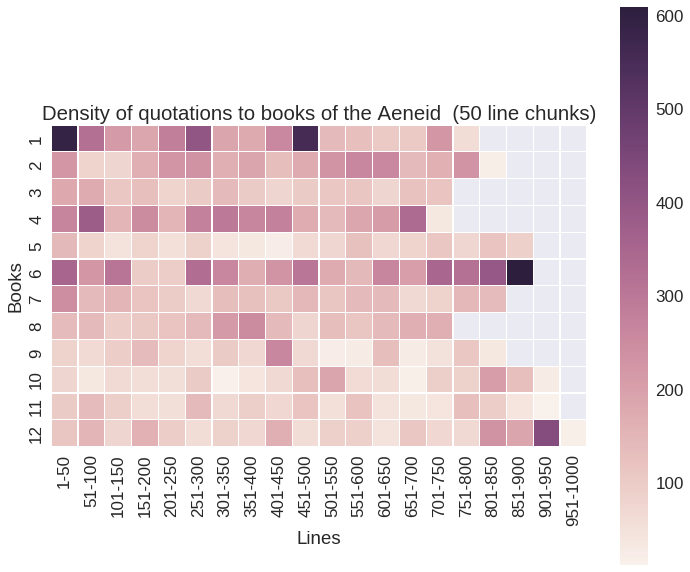

In [16]:
sns.set_context("notebook", font_scale=1.7)
plt.figure(figsize=(12, 10))
ax = sns.heatmap(quotation_freq_df,square=True,linewidths=.2)
ax.set_title("Density of quotations to books of the Aeneid  (50 line chunks)")
ax.set_xlabel('Lines')
ax.set_ylabel('Books')

In [17]:
ax.figure.savefig('quotation_freq_heatmap.png')


## Get the Latin text of the Aeneid from Perseus (via CTS API) 

http://cts.perseids.org/api/cts/?request=GetPassagePlus&urn=urn:cts:latinLit:phi0690.phi003:1.1

In [2]:
import MyCapytain

ImportError: No module named MyCapytain